## PGM Project

### ECG5000

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel
from MAGMA import MAGMA
from trainer_gp_magma import Trainer_GP_MAGMA

### Data

In [2]:
DATA_PATH = "../datasets/ECG5000/"
DATA_PATH = "datasets/ECG5000/"
ecg_train = np.array(pd.read_table(DATA_PATH + "ECG5000_TRAIN.tsv"))
ecg_test = np.array(pd.read_table(DATA_PATH + "ECG5000_TEST.tsv"))
ecg_x_train, ecg_y_train = ecg_train[:, 1:], ecg_train[:, 0]
ecg_x_test, ecg_y_test = ecg_test[:, 1:], ecg_test[:, 0]
ecg_x_train.shape, ecg_x_test.shape

((499, 140), (4499, 140))

In [3]:
ecg_x = np.concatenate([ecg_x_train, ecg_x_test])
ecg_y = np.concatenate([ecg_y_train, ecg_y_test])
print(np.unique(ecg_y_train, return_counts=True))
print(np.unique(ecg_y_test, return_counts=True))
print(np.unique(ecg_y, return_counts=True))

(array([1., 2., 3., 4., 5.]), array([291, 177,  10,  19,   2]))
(array([1., 2., 3., 4., 5.]), array([2626, 1590,   86,  175,   22]))
(array([1., 2., 3., 4., 5.]), array([2917, 1767,   96,  194,   24]))


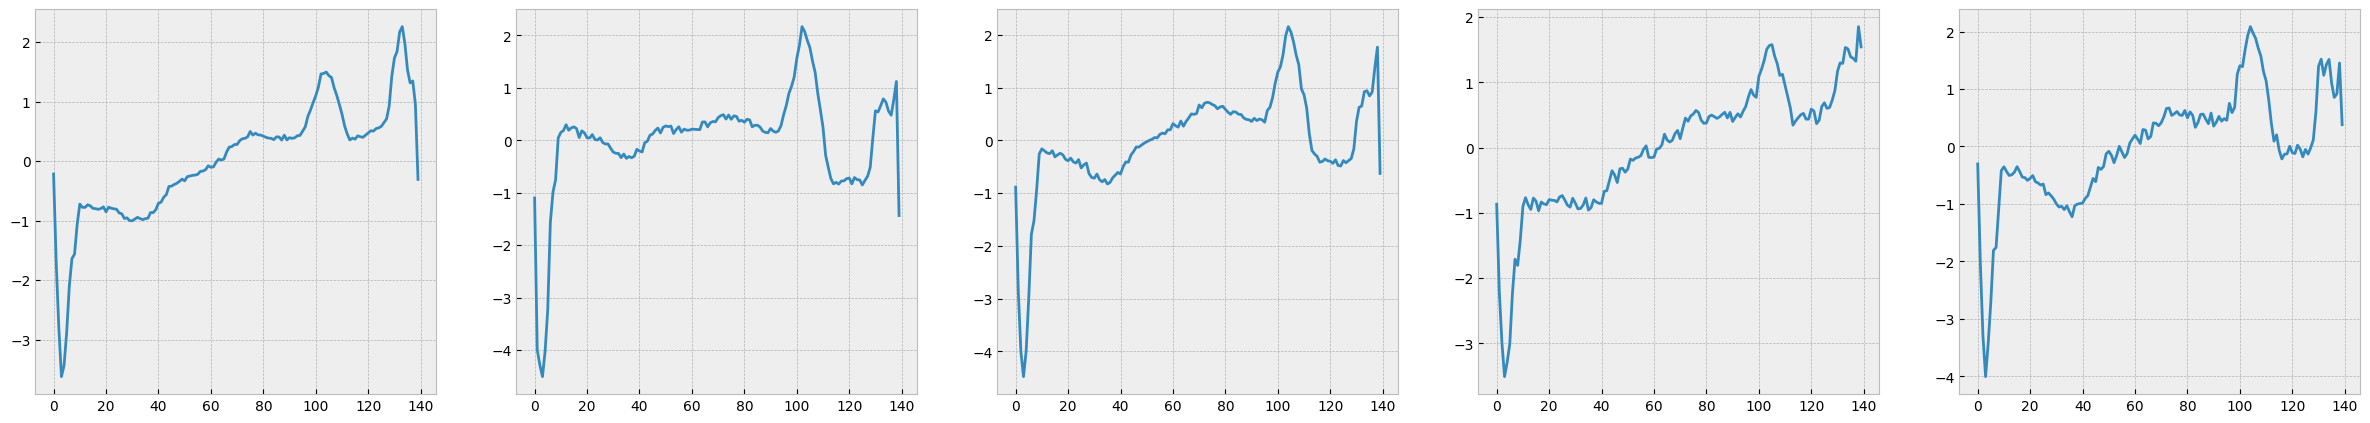

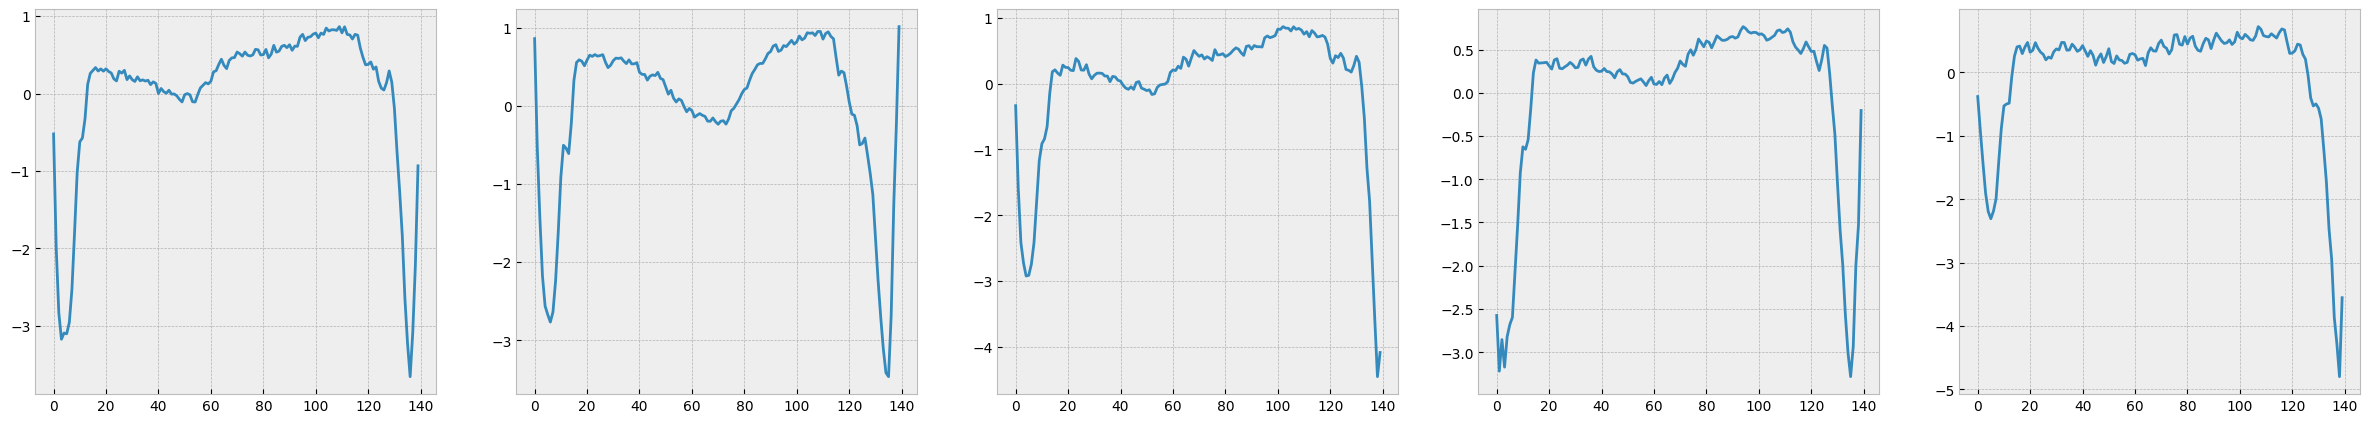

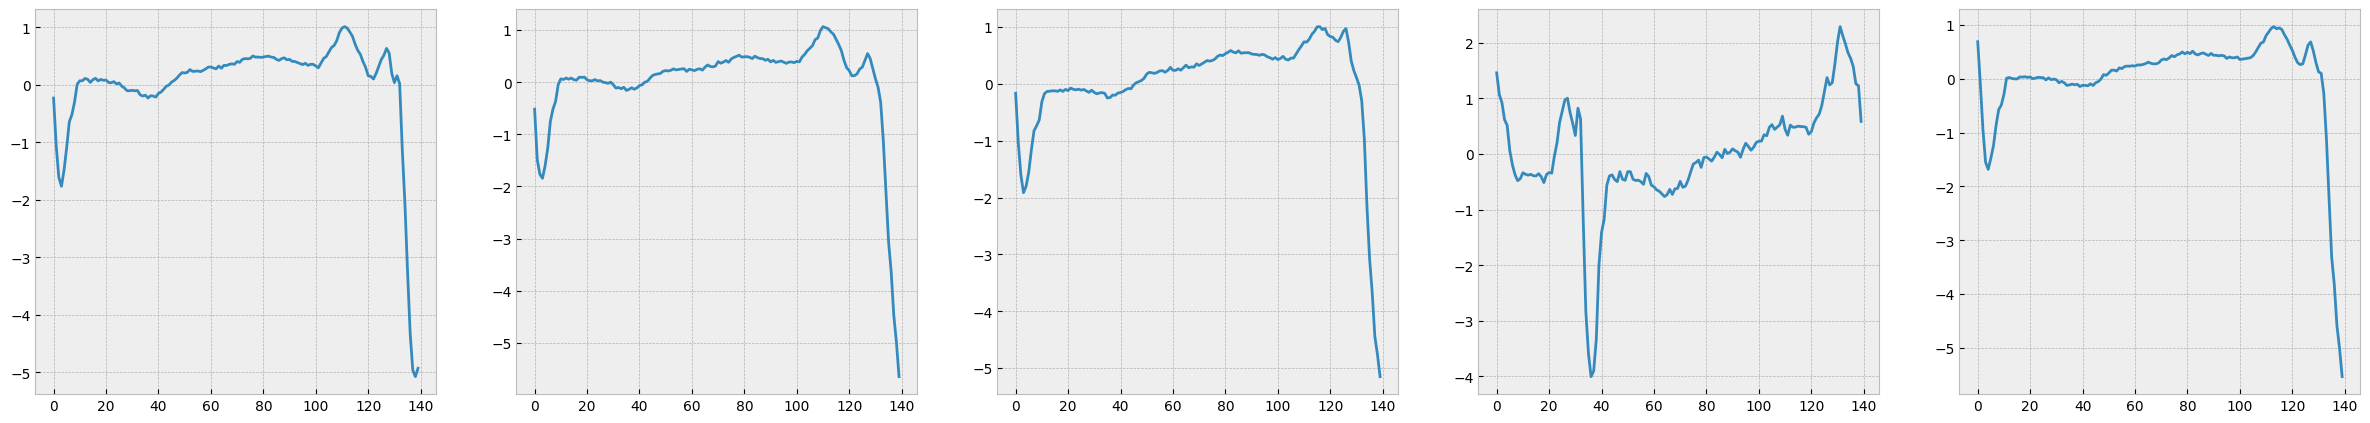

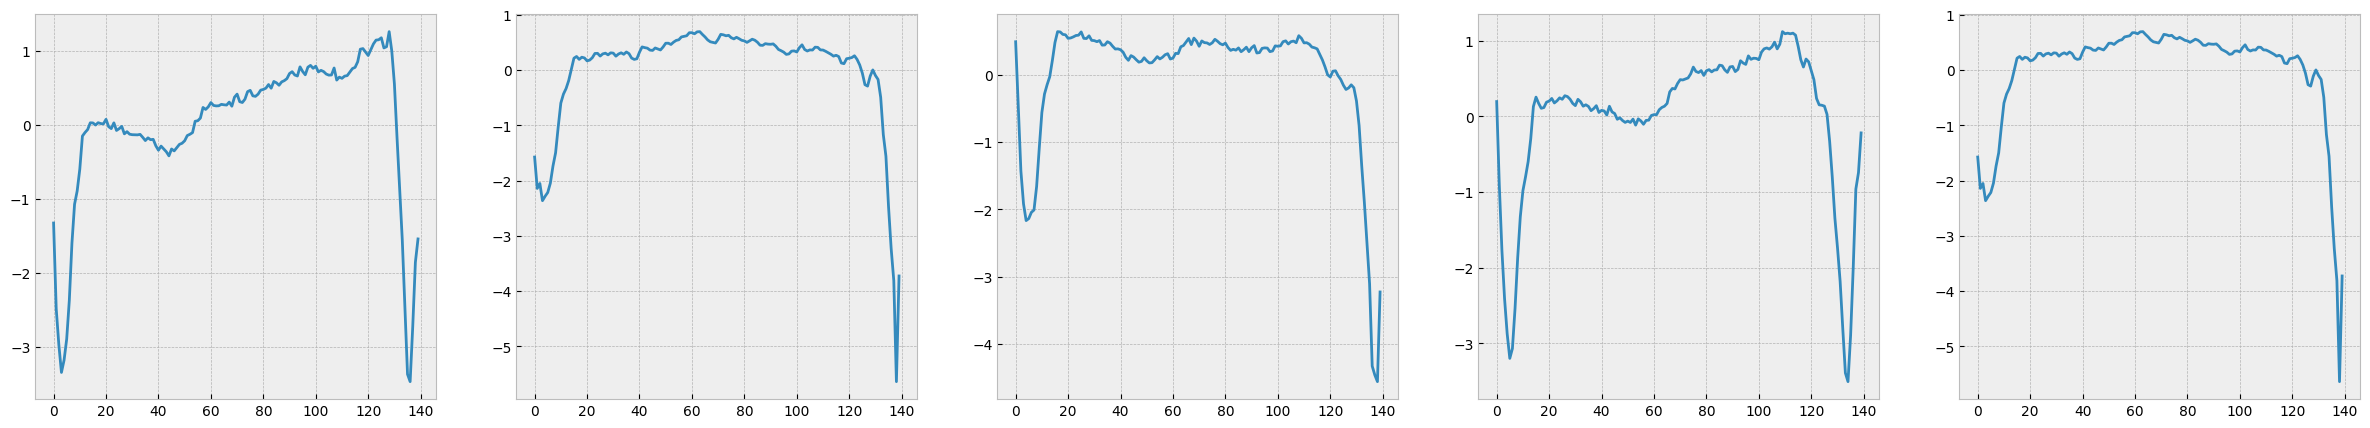

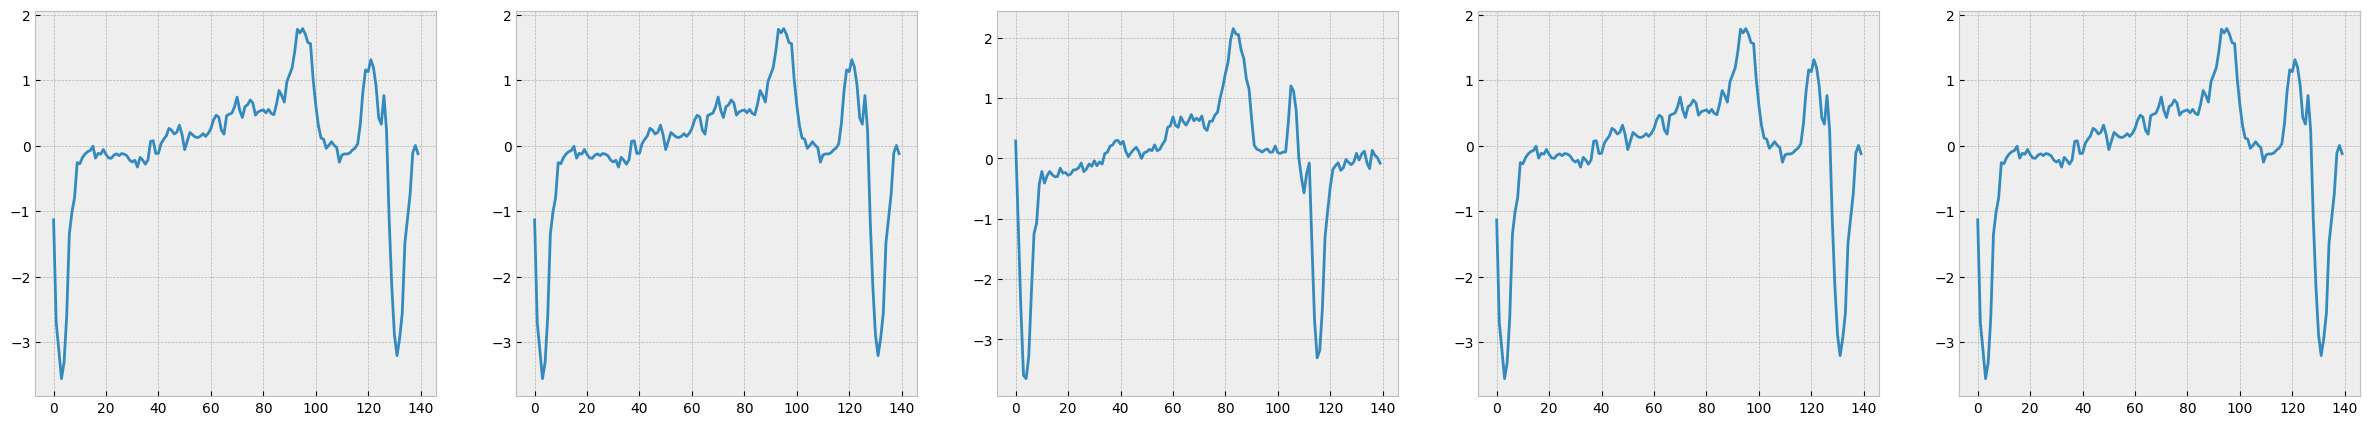

In [4]:
for y in np.unique(ecg_y_train):
    plt.figure(figsize=(30, 5))
    x_train = ecg_x_train[ecg_y_train == y]
    for i, idx in enumerate(np.random.randint(len(x_train), size=5), 1):
        plt.subplot(1, 5, i)
        plt.plot(x_train[idx])
    plt.show()

### Common grid : 60% observed, 40% unobserved

In [5]:
T = np.arange(0, 140)
N = 84
common_T = T[:N]
T_p = T[N:]

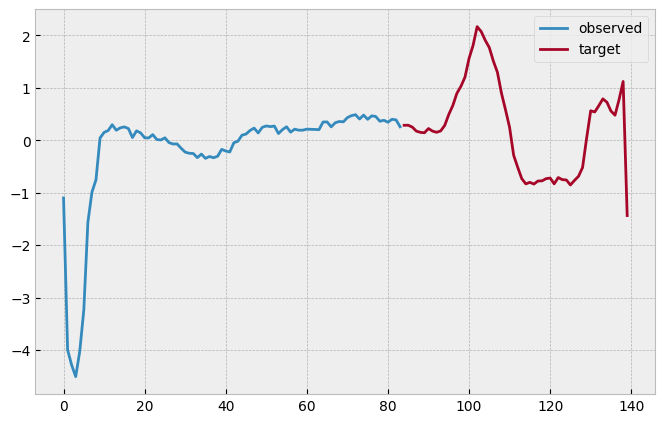

In [6]:
x = ecg_x_train[0]
x_obs = x[:N]
x_p = x[N:]
plt.figure(figsize=(8, 5))
plt.plot(common_T, x_obs, label="observed")
plt.plot(T_p, x_p, label='target')
plt.legend()
plt.show()

#### M = 5 : One individual per classe

In [7]:
Y = np.zeros((5, N))
for y in range(1, 6):
    Y[y-1] = ecg_x_train[ecg_y_train == y][0][:N]

##### Common HP

In [8]:
trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.array([np.exp(1), np.exp(1)]),
    Theta=np.array([np.exp(1), np.exp(1)]),
    Sigma=0.4,
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [9]:
trainer.train_models(max_iterations=20, eps=1e-2)

MAGMA Training: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


###### Evaluation on train set

In [10]:
ecg_x_train_obs = ecg_x_train[:, :N]
ecg_x_train_p = ecg_x_train[:, N:]
ecg_x_train_obs.shape, ecg_x_train_p.shape

((499, 84), (499, 56))

In [11]:
mean_true_p = ecg_x_train_p.mean(axis=0)
mean_true_p.shape

(56,)

In [16]:
T_obss = np.tile(common_T, (len(ecg_x_train_p), 1))
T_ps = np.tile(T_p, (len(ecg_x_train_p), 1))
mean_true_ps = np.tile(mean_true_p, (len(ecg_x_train_p), 1))
T_obss.shape, T_ps.shape, mean_true_ps.shape

((499, 84), (499, 56), (499, 56))

In [18]:
all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, ecg_x_train_obs)

Evaluation: 100%|██████████| 499/499 [02:00<00:00,  4.14it/s]


In [20]:
all_res = np.array(all_res)
all_res.shape

(499, 2)

In [23]:
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")

Magma : 0.3662431745841642 (0.033862335902823074)
GPs : 0.40063830766783504 (2.3314683517128287e-15)


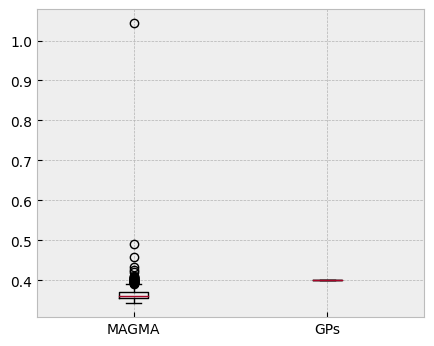

In [25]:
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()